In [21]:
import pickle
from copy import deepcopy
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor

from typing import Optional

from scripts.config import *
from scripts.data_processing.common_methods import get_processed_data, get_available_dataset_ids, get_features_from_pulse_data_v2, get_features_from_pulse_data_v4
from scripts.modeling.fine_tuning import Splitting_Parameters, TransferLearning_Parameters, FineTuning_Parameters, perform_transfer_learning

soc_bol = r"$SOC_{BOL}$"

## Fine-Tuning Performance when Transferring Between Pulse SOC Groups


The below cell shows an example of how to define the parameters in a fine-tuning test with a single SOC source and single SOC target

In [2]:
# How to split source and target data: 66% of all cells will be used in the source dataset, 33% will be in the target
st_params = Splitting_Parameters(
    split_unit='cell', split_method='percent', train_size=0.66, train_soh_bound=0.8, stratify=False, normalize=True)

# How to split the source train and test: 66% of source cells will be for training
s_params = Splitting_Parameters(
    split_unit='cell', split_method='percent', train_size=0.66, train_soh_bound=0.8, stratify=True, normalize=True)

# How to split the target train and test: 5 of the target cells will be for training
t_params = Splitting_Parameters(
    split_unit='cell', split_method='count', train_size=5, train_soh_bound=0.8, stratify=False, normalize=True)

tl_params = TransferLearning_Parameters(
    dataset_id='UConn-ILCC-LFP',
    pulse_type='chg',
    source_soc=20,
    target_soc=50,
    source_target_split_params=st_params,
    source_train_split_params=s_params,
    target_train_split_params=t_params,
    ft_params=FineTuning_Parameters(),
    rand_seed=13
)

res = perform_transfer_learning(tl_params)
print(res[0])
print("  ", res[1])

2025-02-20 15:12:52.325899: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  Seed: 13
UConn-ILCC-LFP_chg_20->50
   {'so_mae': 2.218737212182929, 'so_rmse': 2.89824699764474, 'so_mape': 0.02388839379145272, 'so_r2': 0.6158569184254503, 'dt_mae': 3.732045474421519, 'dt_rmse': 5.632501629879727, 'dt_mape': 0.042415128364277264, 'dt_r2': 0.011670115401976267, 'ft_mae': 3.445722648525083, 'ft_rmse': 4.825216486709814, 'ft_mape': 0.03902512901238466, 'ft_r2': 0.27467460785727693, 'to_mae': 2.782450580144012, 'to_rmse': 3.507848414049274, 'to_mape': 0.030881808206522057, 'to_r2': 0.616662848884951}


The below cell extends the above example to perform multi-SOC source to single-SOC target

In [3]:
tl_params = TransferLearning_Parameters(
    dataset_id='UConn-ILCC-LFP',
    pulse_type='chg',
    source_soc=[20,90],
    target_soc=50,
    source_target_split_params=st_params,
    source_train_split_params=s_params,
    target_train_split_params=t_params,
    ft_params=FineTuning_Parameters(),
    rand_seed=13
)

res = perform_transfer_learning(tl_params)
print(res[0])
print("  ", res[1])

  Seed: 13
Could not find optimal source model. Using default model size.
UConn-ILCC-LFP_chg_[20, 90]->50
   {'so_mae': 2.058872244103681, 'so_rmse': 2.787234715947886, 'so_mape': 0.022238271309601255, 'so_r2': 0.6447211847305234, 'dt_mae': 3.3445803424754974, 'dt_rmse': 4.73123494132684, 'dt_mape': 0.03759364398796408, 'dt_r2': 0.30265401540398074, 'ft_mae': 3.159792131865787, 'ft_rmse': 4.213690698540991, 'ft_mape': 0.03541752089655882, 'ft_r2': 0.44687335143541795, 'to_mae': 2.788290176347769, 'to_rmse': 3.5380178784721976, 'to_mape': 0.030870124902380874, 'to_r2': 0.6100406644316942}


Fine-tuning optimization was performed for a large set of hyperparameters. Note that the source model parameter (model size, activation functions, etc) were optimized prior to optimizing the fine-tuning parameters. These optimizations are shown in "model_optimization.ipynb".

Here, we can plot the fine-tuning performance on the target test set. This can be shown as an absolute metric (eg, fine-tuning MAPE on target test set) or as a relative performance vs a direct-transfer or target-only model (eg, percent change in error between fine-tuning and direct-transfer target test accuracy)



In [4]:
from scripts.modeling.fine_tuning import get_soc_error_results, plot_soc_combination_grid, get_finetuning_errors, plot_finetuning_errors
from scripts.modeling.fine_tuning import PercentChange, AbsoluteChange

plot_soc_combination_grid() will plot the generic heatmap figure for a set of errors organized into a 2D-array with axes: [target_socs][source_socs] 

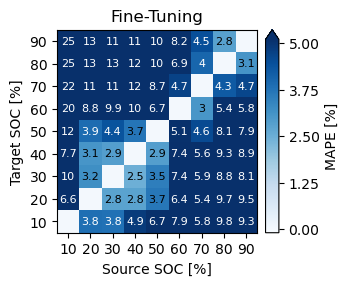

In [5]:
dataset_id = 'UConn-ILCC-NMC'
pulse_type = 'chg'
all_socs = dic_available_dataset_info[dataset_id]['pulse_socs_tested']

res = get_soc_error_results(
	dataset_id=dataset_id,
	pulse_type=pulse_type,
	results_to_show='source_on_target', 
	error_metric='mape', 
	return_type='mean',
	remove_outliers=False)
fig, ax, cbar = plot_soc_combination_grid(
    results=res,
    annotations=np.where(res > 10, np.round(res), np.round(res, 1)),
    
	figsize=(3.375,2.75),
    title='Fine-Tuning', 
    xlabel='Source SOC [%]',
    ylabel='Target SOC [%]',
    xticklabels=all_socs,
    yticklabels=all_socs,
    error_bounds=(0,5),
    annotation_fontsize=8,
)
cbar.set_label("MAPE [%]")

In [6]:
# Prints the average target test error of each approach 
for chemistry in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']:
	for pulse_type in ['chg', 'dchg']:
		print(f"{chemistry} {pulse_type}: ")
		for r2s in ['source_on_target', 'target_only', 'fine_tuning']:
			res = {}
			for metric in ['mape', 'rmse']:
				err = get_soc_error_results(
					dataset_id=chemistry,
					pulse_type=pulse_type,
					results_to_show=r2s, 
					error_metric=metric, 
					return_type='mean',
					remove_outliers=False)
				mean_err = np.mean( err[np.where(err != 0)] )
				res[metric] = mean_err
			print(f"  {r2s}: MAPE={round(res['mape'], 3)}  RMSE={round(res['rmse'], 3)}")
				

UConn-ILCC-LFP chg: 
  source_on_target: MAPE=3.271  RMSE=4.002
  target_only: MAPE=2.851  RMSE=3.399
  fine_tuning: MAPE=2.596  RMSE=3.092
UConn-ILCC-LFP dchg: 
  source_on_target: MAPE=2.988  RMSE=3.576
  target_only: MAPE=2.82  RMSE=3.333
  fine_tuning: MAPE=2.588  RMSE=3.09
UConn-ILCC-NMC chg: 
  source_on_target: MAPE=7.889  RMSE=8.07
  target_only: MAPE=3.65  RMSE=3.846
  fine_tuning: MAPE=3.061  RMSE=3.34
UConn-ILCC-NMC dchg: 
  source_on_target: MAPE=5.948  RMSE=6.068
  target_only: MAPE=4.055  RMSE=4.243
  fine_tuning: MAPE=3.127  RMSE=3.388


Note that `get_soc_error_results(..., results_to_show=source_on_source, ...)` has off-diagonal values, despite the errors only representing the source model's accuracy on the source test data. A better way to represent this source error is to plot only on the diagonals, or to remove the 'Target SOC [%]' y-axis altogether. Examples of each are shown below.

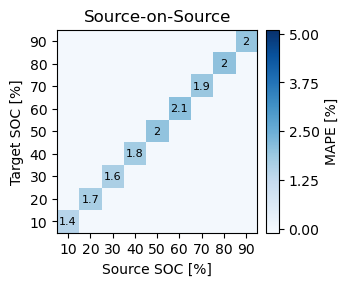

In [7]:
def avg_source_errs_to_diagonal(results):
    #region: source-on-source tests only ever check same SOC --> set values on diagonal, zeros elsewhere
	# if results_to_show == 'source_on_source':
	# get avg error for each source SOC (ignoring zero values)
	source_errs = np.nanmean(np.where(results!=0, results, np.nan), axis=0)
	diag_idxs = np.diag_indices(results.shape[0])			# get indices of diagonal
	triu_idxs = np.triu_indices(results.shape[0], k=1)	 	# get indices of upper right triangle
	tril_idxs = np.tril_indices(results.shape[0], k=-1)  	# get indices of lower right triangle
	results[diag_idxs] = source_errs
	results[triu_idxs] = np.zeros_like( results[0,0] )
	results[tril_idxs] = np.zeros_like( results[0,0] )
	results[diag_idxs] = source_errs
	#endregion
	return results


dataset_id = 'UConn-ILCC-NMC'
pulse_type = 'dchg'
results_to_show = 'source_on_source'

results = get_soc_error_results(
	dataset_id=dataset_id,
	pulse_type=pulse_type,
	results_to_show=results_to_show,
	error_metric='mape', 
	return_type='mean',
	remove_outliers=False)
results = avg_source_errs_to_diagonal(results)
fig, ax, cbar = plot_soc_combination_grid(
    results=results,
    annotations=results.round(1),
	figsize=(3.375,2.75),
    title='Source-on-Source', 
    xlabel='Source SOC [%]',
    ylabel='Target SOC [%]',
    xticklabels=all_socs,
    yticklabels=all_socs,
    error_bounds=(0,5),
    annotation_fontsize=8,
)
cbar.set_label("MAPE [%]")

/var/folders/21/fsx4ddjs3fg2wgpl7_ksh0k00000gn/T/ipykernel_53593/2557857559.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(res_dict.values(), labels=res_dict.keys(),


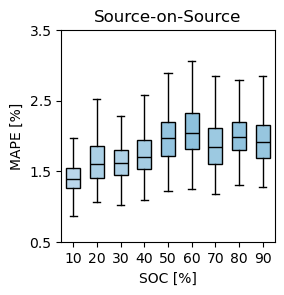

Avg. source model test accuracy in source domain:  1.4314403245845932


In [8]:
# error_metric (str): {'rmse', 'mae', 'mape', 'r2'}
def get_unit_str_from_error_metric(error_metric:str, test_variable_unit:Optional[str]=None):
	assert error_metric in ['rmse', 'mae', 'mape', 'r2']
	if error_metric in ['rmse', 'mae']: 
		assert test_variable_unit is not None, "The specified error metrics has units equal to the test variable. Please provide a value for \'test_variable_unit\'."
	unit_dic = {
		'rmse':test_variable_unit,
		'mae':test_variable_unit,
		'mape':'%',
		'r2':'-'
	}
	return unit_dic[error_metric]

def plot_source_errors_boxplot(dataset_id:str, pulse_type:str, error_metric:str='mape', err_bounds=None, show_outliers=False, **kwargs):
	"""Plots the source model test accuracy (on the source domain) with boxplots for each source SOC. 

	Args:
		dataset_id (str): {'UConn-ILCC-LFP', 'UConn-ILCC-NMC'}
		pulse_type (str): {'chg', 'dchg'}
		error_metric (str, optional): {'mape', 'mae', 'rmse', 'r2'}. Defaults to 'mape'.
		err_bounds (_type_, optional): The y-axis limits. Defaults to None.
		show_outliers (bool, optional): Whether to show outliers in each boxplot. Defaults to False.
		**kwargs: {'figsize', 'xlabel'}
	Returns:
		tuple: fig, ax, res_dict
	"""
	results = get_soc_error_results(
		dataset_id=dataset_id,
		pulse_type=pulse_type,
		results_to_show='source_on_source',
		error_metric=error_metric,
		return_type='values',
		remove_outliers=False)

	res_dict = {}
	all_socs = dic_available_dataset_info[dataset_id]['pulse_socs_tested']
	for i in range(results.shape[1]):
		all_errs = results[:,i,:][np.where(results[:,i,:] != 0)]
		res_dict[f'{all_socs[i]}'] = all_errs

	figsize = (2.75,2.75)
	if 'figsize' in kwargs: figsize = kwargs['figsize']
	xlabel = 'SOC [%]'
	if 'xlabel' in kwargs: xlabel = kwargs['xlabel']

	fig, ax = plt.subplots(figsize=figsize) # (3.375,2.75)
	bplot = ax.boxplot(res_dict.values(), labels=res_dict.keys(),
					patch_artist=True, 
					widths=0.6 if dataset_id == 'UConn-ILCC-NMC' else 0.75,
					showfliers=show_outliers,
					flierprops={'marker': '.', 'markersize': 5})

	# fill each boxplot with color base on MAPE error
	scm = mpl.cm.ScalarMappable(cmap=mpl.cm.Blues, norm=mpl.colors.Normalize(vmin=0, vmax=5))
	colors = [scm.to_rgba(np.mean(res_dict[k])) for k in res_dict.keys()]
	for patch, median, color in zip(bplot['boxes'], bplot['medians'], colors):
		patch.set_facecolor(color)
		patch.set_edgecolor('black')
		median.set_color('black')
	ax.set_xlabel(xlabel) # ax.set_xlabel("Source SOC [%]")
	ax.set_ylabel(f"{error_metric.upper()} [{get_unit_str_from_error_metric(error_metric=error_metric, test_variable_unit='%')}]")
	
	if err_bounds is None:
		all_vals = None
		if show_outliers:
			all_vals = np.asarray(list(res_dict.values())).flatten()
		else:
			all_vals = []
			for whisker in bplot['whiskers']:
				all_vals.extend(whisker.get_data()[1])	# get y_data from each whisker
		err_bounds = (np.floor(np.min(all_vals)), np.ceil(np.max(all_vals)))
	ax.set_ylim(err_bounds)
	ax.set_yticks(np.arange(err_bounds[0], err_bounds[1]+0.5, 1))
	ax.set_title("Source-on-Source")
	return fig, ax, res_dict

fig, ax, res_dict = plot_source_errors_boxplot(
	dataset_id='UConn-ILCC-NMC',
	pulse_type='dchg',
	error_metric='mape',
	err_bounds=(0.5,3.5),
)
plt.show()
print("Avg. source model test accuracy in source domain: ", np.mean(res_dict['10']))

The cell below performs the same plotting code as the cell above but for every combination of chemistry and pulse type. 

The figures are saved to: *figures/Fine-Tuning Error*

In [ ]:
from scripts.modeling.fine_tuning import fine_tuning_result_keys

#region: plot SOC combination grid for all combination of chemistry, pulse type, and error type
error_metric = 'mape'
error_bounds = (0,5)
dir_save = dir_figures.joinpath("Fine-Tuning Error")
dir_save.mkdir(exist_ok=True, parents=True)
file_type = 'pdf'
soc_bol = r"$SOC_{BOL}$"

title_map = {
	'source_on_source':'Source-on-Source', 
	'source_on_target':'Source-on-Target', 
	'target_only':'Target-Only',
	'fine_tuning':'Fine-Tuning', 
}
for dataset_id in ['UConn-ILCC-NMC', 'UConn-ILCC-LFP']:
	all_socs = dic_available_dataset_info[dataset_id]['pulse_socs_tested']
	for pulse_type in ['chg', 'dchg']:
		for result_to_show in ['source_on_source', 'source_on_target', 'target_only', 'fine_tuning']:
			res = get_soc_error_results(
				dataset_id=dataset_id,
				pulse_type=pulse_type,
				results_to_show=result_to_show, 
				error_metric=error_metric, 
				return_type='mean',
				remove_outliers=False)
			
			# if result_to_show == 'source_on_source':
			# 	res = avg_source_errs_to_diagonal(res)

			fig, ax, cbar = plot_soc_combination_grid(
				results=res,
				annotations=np.where(res > 10, np.round(res), np.round(res, 1)),
				
				figsize=(3.375,2.75),
				title=title_map[result_to_show], 
				xlabel=f'Source {soc_bol} [%]',
				ylabel=f'Target {soc_bol} [%]',
				xticklabels=all_socs,
				yticklabels=all_socs,
				error_bounds=error_bounds,
				annotation_fontsize=8,
			)
			cbar.set_label(f"{error_metric.upper()} [{'%' if error_metric == 'mape' else '-'}]")

			result_shorthand = fine_tuning_result_keys['model_error_names'][result_to_show]
			filename = f"Error_{dataset_id}_{pulse_type}_{result_shorthand}.{file_type}"
			fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
			plt.close()

		fig, _ax, _ = plot_source_errors_boxplot(
			dataset_id=dataset_id,
			pulse_type=pulse_type,
			error_metric=error_metric,
			err_bounds=(0.5, 3.5),
			show_outliers=False,
			figsize=(1.75, 1.75),	# (2.75, 2.75)
			xlabel=f'Source {soc_bol} [%]',
		)
		_ax.title.set_size(8)
		_ax.xaxis.label.set_size(8)
		_ax.yaxis.label.set_size(8)
		_ax.tick_params(labelsize=8)
		filename = f"SourceError_{dataset_id}_{pulse_type}.{file_type}"
		fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
		plt.close()
#endregion

#region: plot all error types for a chemistry/pulse type as one figure
for dataset_id in ['UConn-ILCC-NMC', 'UConn-ILCC-LFP']:
	all_socs = dic_available_dataset_info[dataset_id]['pulse_socs_tested']
	for pulse_type in ['chg', 'dchg']:
		
		fig = plt.figure(figsize=(8,1.75))
		gs = GridSpec(figure=fig, nrows=1, ncols=5, width_ratios=[10,10,10,10,1], wspace=0.15)
		axes = (fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,2]), fig.add_subplot(gs[0,3]), fig.add_subplot(gs[0,4]))
		for i in range(1,4):
			axes[i].sharey(axes[0])
			axes[i].tick_params(labelleft=False)

		for i, result_to_show in enumerate(['source_on_source', 'source_on_target', 'target_only', 'fine_tuning']):
			res = get_soc_error_results(
				dataset_id=dataset_id,
				pulse_type=pulse_type,
				results_to_show=result_to_show, 
				error_metric=error_metric, 
				return_type='mean',
				remove_outliers=False)

			# if result_to_show == 'source_on_source':
			# 	res = avg_source_errs_to_diagonal(res)

			_, _axes, cbar = plot_soc_combination_grid(
				results=res,
				annotations=np.where(res > 10, np.round(res), np.round(res, 1)),
				
				fig=fig,
				axes=(axes[i], axes[4]),
				title=title_map[result_to_show], 
				xlabel=f'Source {soc_bol} [%]',
				ylabel=f'Target {soc_bol} [%]' if i == 0 else '',
				xticklabels=all_socs,
				yticklabels=all_socs,
				error_bounds=(0,5),
				annotation_fontsize=5 if 'NMC' in dataset_id else 7,
			)
			_axes[0].title.set_size(8)
			_axes[0].xaxis.label.set_size(8)
			_axes[0].yaxis.label.set_size(8)
			_axes[0].tick_params(labelsize=8)
			cbar.set_label(f"{error_metric.upper()} [{'%' if error_metric == 'mape' else '-'}]", fontsize=8)
			cbar.ax.tick_params(labelsize=8)

		filename = f"Errors_{dataset_id}_{pulse_type}_All.{file_type}"
		fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
		plt.close()
#endregion


Next, we'll plot the relative improvements of fine-tuning using both percent change and the error difference

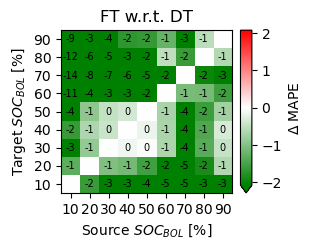

In [11]:
res = get_finetuning_errors(
	dataset_id='UConn-ILCC-NMC',
	pulse_type='dchg',
	results_to_compare=('fine_tuning', 'source_on_target'),
	error_metric='mape',
	error_difference_fnc=AbsoluteChange,
	remove_outliers=False
)

fig, ax, cbar = plot_finetuning_errors(
	results=res,
	annotation_type='mean',

	figsize=(3,2.375),
	annotation_fontsize=7,
	cmap=mpl.colors.LinearSegmentedColormap.from_list('rg',["green", "white", "red"], N=256),
	error_bounds=(-2,2),
	cbar_nticks=5)
cbar.set_label(r"$\Delta$ MAPE")
plt.show()


The cell below performs the same plotting code as the cell above but for every combination of chemistry and pulse type. 

The figures are saved to: *figures/Fine-Tuning Error*

In [6]:
#region: plot Absolute Error Difference (finetuning error - other model error)
error_metric = 'mape'
error_bounds = (-2,2)
error_diff_fnc = AbsoluteChange
dir_save = dir_figures.joinpath("Fine-Tuning Error")
dir_save.mkdir(exist_ok=True, parents=True)
file_type = 'png'

for dataset_id in ['UConn-ILCC-NMC', 'UConn-ILCC-LFP']:
	all_socs = dic_available_dataset_info[dataset_id]['pulse_socs_tested']
	for pulse_type in ['chg', 'dchg']:
		for results_to_show in [('fine_tuning', 'source_on_target'), ('fine_tuning', 'target_only')]:
			res = get_finetuning_errors(
				dataset_id=dataset_id,
				pulse_type=pulse_type,
				results_to_compare=results_to_show,
				error_metric=error_metric,
				error_difference_fnc=error_diff_fnc,
				remove_outliers=False
			)
			fig, axes, cbar = plot_finetuning_errors(
				results=res,
				annotation_type='mean',
				figsize=(2.875,2.375),
				annotation_fontsize= 6 if 'NMC' in dataset_id else 8,
				cmap=mpl.colors.LinearSegmentedColormap.from_list('rg',["green", "white", "red"], N=256),
				error_bounds=error_bounds,
				cbar_nticks=5,
			)
			delta = r"$\Delta$"
			cbar.set_label(f"{delta} {error_metric.upper()}")
			filename = f"ErrorDiff_Abs_{dataset_id}_{pulse_type}_{axes[0].get_title()}.{file_type}"
			fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
			plt.close()
#endregion

#region: plot Percent Change of Error
error_bounds = (-50,50)
error_diff_fnc = PercentChange

for dataset_id in ['UConn-ILCC-NMC', 'UConn-ILCC-LFP']:
	all_socs = dic_available_dataset_info[dataset_id]['pulse_socs_tested']
	for pulse_type in ['chg', 'dchg']:
		for results_to_show in [('fine_tuning', 'source_on_target'), ('fine_tuning', 'target_only')]:
			res = get_finetuning_errors(
				dataset_id=dataset_id,
				pulse_type=pulse_type,
				results_to_compare=results_to_show,
				error_metric=error_metric,
				error_difference_fnc=error_diff_fnc,
				remove_outliers=False
			)
			fig, axes, cbar = plot_finetuning_errors(
				results=res,
				annotation_type='mean',

				figsize=(2.875,2.375),
				annotation_fontsize= 6 if 'NMC' in dataset_id else 8,
				cmap=mpl.colors.LinearSegmentedColormap.from_list('rg',["green", "white", "red"], N=256),
				error_bounds=error_bounds,
				cbar_nticks=5
			)
			cbar.set_label(f"Percent Change of {error_metric.upper()}")
			filename = f"ErrorDiff_Pct_{dataset_id}_{pulse_type}_{axes[0].get_title()}.{file_type}"
			fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
			plt.close()
#endregion


Below looks at the average relative fine-tuning performance across each source domain. The most negative error difference indicates the most useful source SOC for all other target SOCs.

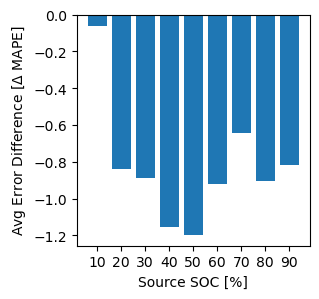

In [12]:
dataset_id = 'UConn-ILCC-NMC'
pulse_type = 'dchg'
res = get_finetuning_errors(
	dataset_id=dataset_id,
	pulse_type=pulse_type,
	results_to_compare=('fine_tuning', 'target_only'),
	error_metric='mape',
	error_difference_fnc=AbsoluteChange,
	remove_outliers=False
)

fig, ax = plt.subplots(figsize=(3,3))
for i, source_soc in enumerate(np.arange(10,91,10)):
	avg_err = res['mean'][:,i].mean()
	ax.bar(source_soc, avg_err, width=8, color='C0')

ax.set_xlabel("Source SOC [%]")
ax.set_xticks(np.arange(10,91,10))
ax.set_ylabel(r"Avg Error Difference [$\Delta$ MAPE]")
plt.show()

In [13]:
print("Average MAPE across all source-to-target SOC combinations for the following:")
for result_to_show in ['source_on_source', 'source_on_target', 'fine_tuning', 'target_only']:
	res = get_soc_error_results(
		dataset_id='UConn-ILCC-NMC',
		pulse_type='dchg',
		results_to_show=result_to_show, 
		error_metric='mape', 
		return_type='mean',
		remove_outliers=False)
	
	print(f"  {result_to_show}: {np.average(res[res != 0], axis=None).round(5)} %")


print()
print("Average percent change in MAPE for fine-tuning wrt target-only:")
res_dic = get_finetuning_errors(
	dataset_id='UConn-ILCC-NMC',
	pulse_type='dchg',
	results_to_compare=('fine_tuning', 'target_only'),
	error_metric='mape',
	error_difference_fnc=PercentChange,
	remove_outliers=False
)
print(f"  FT wrt TO: {np.average(res_dic['mean'][res_dic['mean'] != 0], axis=None).round(5)} %")


Average MAPE across all source-to-target SOC combinations for the following:
  source_on_source: 1.83302 %
  source_on_target: 5.94794 %
  fine_tuning: 3.12698 %
  target_only: 4.05522 %

Average percent change in MAPE for fine-tuning wrt target-only:
  FT wrt TO: -18.07922 %


## Low Level Plots of FT Errors

For a given source to target SOC, show:
* $y$ vs $\hat{y}$ for SO, DT, FT, & TO
* Cells selected for source/target and train/test
* Maybe show 2 SOC combinations, for good FT & bad FT

Unfortunately, the saved 100-iteration tests only store the error metrics (e.g., MAPE values). They don't record the individual SOH predictions for each trial, so we need to re-run the fine-tuning framework using the cell splits recorded in the results.


In [17]:
def find_best_iter(dataset_id, pulse_type, source_soc, target_soc):
    
	dir_save = dir_results.joinpath("plotting_data", "finetuning_eval", f"{dataset_id} {pulse_type.upper()}")
	dir_save.mkdir(exist_ok=True, parents=True)
	filename = f"ModelErrors ({source_soc}-to-{target_soc}).pkl"
	

	#region: load data
	df_saved_results = None
	for f in dir_results.joinpath('finetuning_optimization', 'st_split_by_cell', 'FixedParameters').glob('*.pkl'):
		df_f = pickle.load(open(f, 'rb'))
		if df_saved_results is None: df_saved_results = df_f
		else: df_saved_results = pd.concat([df_saved_results, df_f], ignore_index=True)
	df_saved_results = df_saved_results.loc[
		(df_saved_results['dataset_id'] == dataset_id) & \
		(df_saved_results['pulse_type'] == pulse_type) & \
		(df_saved_results['source_soc'].astype(int) == source_soc) & \
		(df_saved_results['target_soc'].astype(int) == target_soc)]
	assert len(df_saved_results) == 100
	#endregion

	for iter_idx in range(len(df_saved_results)):
		if dir_save.joinpath(filename).exists():
			df_res = pickle.load(open(dir_save.joinpath(filename), 'rb'))
			if iter_idx in df_res['rand_seed'].unique(): 
				print(f"Iteration {iter_idx} already processed. Skipping.")
				continue
		else: df_res = None

		source_train_ids = str_list_to_list(df_saved_results.iloc[iter_idx]['source_train_ids']).astype(int)
		source_test_ids = str_list_to_list(df_saved_results.iloc[iter_idx]['source_test_ids']).astype(int)
		target_train_ids = str_list_to_list(df_saved_results.iloc[iter_idx]['target_train_ids']).astype(int)
		target_test_ids = str_list_to_list(df_saved_results.iloc[iter_idx]['target_test_ids']).astype(int)

		# Run fine-tuning framework for these parameters
		tl_params = TransferLearning_Parameters(
			dataset_id=dataset_id,
			pulse_type=pulse_type,
			source_soc=source_soc,
			target_soc=target_soc,
			source_target_split_params=Splitting_Parameters(
				split_unit		= 'cell', 
				train_ids		= np.hstack([source_train_ids, source_test_ids]),
				test_ids		= np.hstack([target_train_ids, target_test_ids]),
				train_soh_bound = 0.80,
				stratify        = True,
				normalize       = False 	),
			source_train_split_params=Splitting_Parameters(
				split_unit		= 'cell', 
				train_ids		= source_train_ids, 
				test_ids		= source_test_ids,
				train_soh_bound = 0.80,
				stratify        = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['source_stratify'],
				normalize       = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['source_normalize']			),
			target_train_split_params=Splitting_Parameters(
				split_unit		= 'cell', 
				train_ids		= target_train_ids, 
				test_ids		= target_test_ids,
				train_soh_bound = 0.80,
				stratify        = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['target_stratify'],
				normalize       = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['target_normalize']			),
			ft_params=FineTuning_Parameters(
				n_retrain_layers    = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_n_retrain_layers'],
				learning_rate_1     = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_learning_rate_1'],
				learning_rate_2     = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_learning_rate_2'],
				epochs_1            = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_epochs_1'],
				epochs_2            = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_epochs_2'],
				batch_size_1        = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_batch_size_1'],
				batch_size_2        = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_batch_size_2'],
				val_split_1         = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_val_split_1'],
				val_split_2         = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_val_split_2'],		),
			rand_seed=iter_idx,
		)
		_, tl_errs = perform_transfer_learning(
			params=tl_params,
			return_all=False
		)

		tl_errs['rand_seed'] = iter_idx
		if df_res is None: df_res = pd.DataFrame([tl_errs])
		else: df_res = pd.concat([df_res, pd.DataFrame([tl_errs])], ignore_index=True)

		pickle.dump(df_res, open(dir_save.joinpath(filename), 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

	print(f"Data saved to: {dir_save.joinpath(filename)}")
	return

def prediction_plot(xs, ys, **kwargs):
    # **kwargs: {'fig', 'ax', 'title', 'xlabel', 'ylabel', 'alpha', 'show_ci', 'show_pi', 'show_fit', 
	# 			 'pi_color', 'pi_alpha', 'ci_color', 'ci_alpha', 'fit_color', 'fit_alpha', 'fit_linewidth', 'fit_linemarker'
	# 			 'marker_color', 'marker_alpha', 'marker', 'marker_size',}

	#region: unpack kwargs
	title, xlabel, ylabel = '', '', ''
	if 'title' in kwargs: title = kwargs['title']
	if 'xlabel' in kwargs: xlabel = kwargs['xlabel']
	if 'ylabel' in kwargs: ylabel = kwargs['ylabel']
	alpha = 0.05
	if 'alpha' in kwargs: alpha = kwargs['alpha']
	fig, ax = None, None
	if 'fig' in kwargs and 'ax' in kwargs: 
		fig = kwargs['fig']
		ax = kwargs['ax']
	else:
		fig, ax = plt.subplots(figsize=(4,3))

	show_ci, show_pi, show_fit = True, True, True
	if 'show_ci' in kwargs: show_ci = kwargs['show_ci']
	if 'show_pi' in kwargs: show_pi = kwargs['show_pi']
	if 'show_fit' in kwargs: show_fit = kwargs['show_fit']

	pi_color = mpl.cm.Blues(0.5)
	pi_alpha = 0.2
	if 'pi_color' in kwargs: pi_color = kwargs['pi_color']
	if 'pi_alpha' in kwargs: pi_alpha = kwargs['pi_alpha']

	ci_color = mpl.cm.Oranges(0.5)
	ci_alpha = 0.5
	if 'ci_color' in kwargs: ci_color = kwargs['ci_color']
	if 'ci_alpha' in kwargs: ci_alpha = kwargs['ci_alpha']

	marker_color = mpl.cm.Blues(0.8)
	marker_alpha = (0.5 if len(xs) < 100 else 0.2)
	marker = '.'
	marker_size = 2 if len(xs) > 100 else 30
	if 'marker_color' in kwargs: marker_color = kwargs['marker_color']
	if 'marker_alpha' in kwargs: marker_alpha = kwargs['marker_alpha']
	if 'marker' in kwargs: marker = kwargs['marker']
	if 'marker_size' in kwargs: marker_size = kwargs['marker_size']

	fit_color = mpl.cm.Oranges(0.8)
	fit_alpha = 1.0
	fit_linewidth = 1.2
	fit_linemarker = '-'
	if 'fit_color' in kwargs: fit_color = kwargs['fit_color']
	if 'fit_alpha' in kwargs: fit_alpha = kwargs['fit_alpha']
	if 'fit_linewidth' in kwargs: fit_linewidth = kwargs['fit_linewidth']
	if 'fit_linemarker' in kwargs: fit_linemarker = kwargs['fit_linemarker']

	show_resid = True
	resid_bounds = None
	if 'show_resid' in kwargs: show_resid = kwargs['show_resid']
	if 'resid_bounds' in kwargs: resid_bounds = kwargs['resid_bounds']

	show_annotations = True
	if 'show_annotations' in kwargs: show_annotations = kwargs['show_annotations']
	#endregion

	#region: calaculate best fit
	import statsmodels.api as sm
	linear_model = sm.OLS(ys.reshape(-1,1), sm.add_constant(xs.reshape(-1,1))).fit()

	# predict best fit line
	x_pred_range = np.linspace(np.min(xs), np.max(xs), 100).reshape(-1,1)
	y_pred = linear_model.predict(sm.add_constant(x_pred_range))
	
	# get prediction and confidence intervals
	_ = linear_model.conf_int(alpha=alpha, cols=None)
	summary = linear_model.get_prediction(sm.add_constant(x_pred_range)).summary_frame()
	#endregion

	#region: plot
	# plotting layers zorder (back --> front): PI, raw data, CI, best fit
	if show_pi:
		ax.fill_between(
			x_pred_range.flatten(),
			summary['obs_ci_lower'].values,
			summary['obs_ci_upper'].values,
			color=pi_color, alpha=pi_alpha, 
			label=f'{round((1-alpha)*100)}% PI',
			zorder=5)
	if show_ci:
		ax.fill_between(
			x_pred_range.flatten(),
			summary['mean_ci_lower'].values,
			summary['mean_ci_upper'].values,
			color=ci_color, alpha=ci_alpha, 
			label=f'{round((1-alpha)*100)}% CI',
			zorder=9)
	
	ax.scatter(
		xs,
		ys, 
		color=marker_color, alpha=marker_alpha, 
		marker=marker, s=marker_size, 
		label='Data',
		zorder=7)
	if show_fit:
		ax.plot(
			x_pred_range, y_pred, fit_linemarker, linewidth=fit_linewidth,
			color=fit_color, alpha=fit_alpha, 
			label='Fit',
			zorder=11)
	axes = ax
	if show_resid:
		resids = xs - ys  # true - pred
		inset_ax = ax.inset_axes(bounds=(0.60,0.12, 0.36, 0.30))

		if not resid_bounds is None:
			bins = np.linspace(resid_bounds[0], resid_bounds[1], endpoint=True, num=15)
			inset_ax.hist(resids, bins=bins, color='gray', edgecolor='black', alpha=0.7)
		else:
			inset_ax.hist(resids, bins=15, color='gray', edgecolor='black', alpha=0.7)
		inset_ax.set_xlim(resid_bounds)
		axes = [ax, inset_ax]
	if show_annotations:
		mape = mean_absolute_percentage_error(xs, ys)
		r2 = r2_score(xs, ys)

		ax.annotate(f"$MAPE={round(mape*100, 3)}\%$", xy=(0.03,0.90), xycoords='axes fraction', fontsize=8)
		ax.annotate(f"$R^2={round(r2, 3)}$", xy=(0.03,0.80), xycoords='axes fraction', fontsize=8)

	
	if not title == '': ax.set_title(title)
	if not xlabel == '': ax.set_xlabel(xlabel, fontsize=8)
	if not ylabel == '': ax.set_ylabel(ylabel, fontsize=8)
	#endregion

	return fig, axes


Source: [27 38 31  7 21  3 13 20 11 44 36 39 18 14 22 34 12 29  2] -> [ 5  8  9 16 24 25 26 35 40 43]
Target: [10 23 42] -> [ 1  4  6 15 17 19 28 30 32 33 37 41]
  Seed: 12


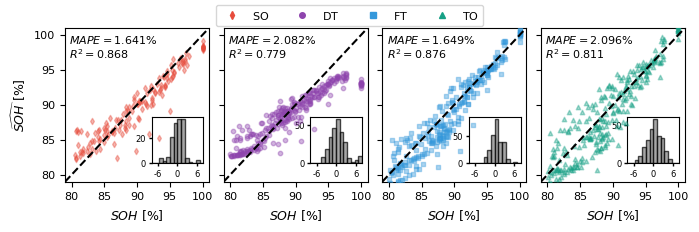

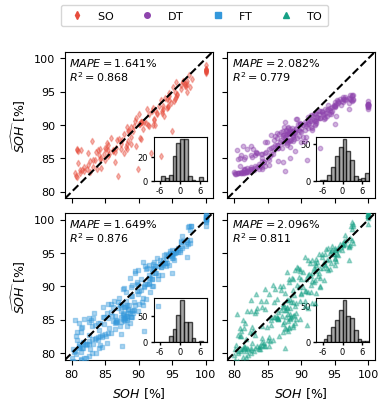

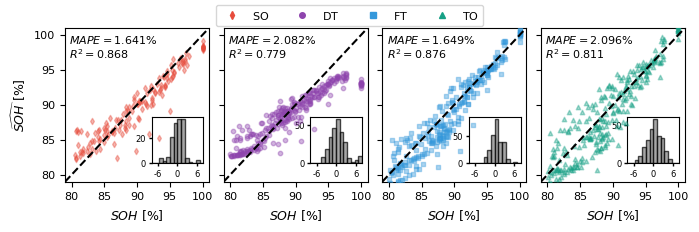

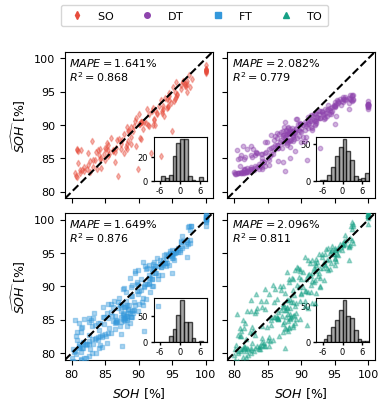

In [18]:
from sklearn.metrics import r2_score
from scripts.modeling.fine_tuning import str_list_to_list, OPTIMAL_TL_PARAMS

# For NMC dchg, 60->30 (iter 17) and 10->60 (iter 83) are shown in Figure 5
dataset_id = 'UConn-ILCC-NMC'
pulse_type = 'dchg'
error_metric = 'mape'
source_soc = 60
target_soc = 30
iter_idx = 12
save = False

#region: get source/target cell splits for each of the 100 iterations
df_saved_results = None
for f in dir_results.joinpath('finetuning_optimization', 'st_split_by_cell', 'FixedParameters').glob('*.pkl'):
	df_f = pickle.load(open(f, 'rb'))
	if df_saved_results is None: df_saved_results = df_f
	else: df_saved_results = pd.concat([df_saved_results, df_f], ignore_index=True)
df_saved_results = df_saved_results.loc[
	(df_saved_results['dataset_id'] == dataset_id) & \
	(df_saved_results['pulse_type'] == pulse_type) & \
	(df_saved_results['source_soc'].astype(int) == source_soc) & \
	(df_saved_results['target_soc'].astype(int) == target_soc)]
assert len(df_saved_results) == 100

source_train_ids = str_list_to_list(df_saved_results.iloc[iter_idx]['source_train_ids']).astype(int)
source_test_ids = str_list_to_list(df_saved_results.iloc[iter_idx]['source_test_ids']).astype(int)
target_train_ids = str_list_to_list(df_saved_results.iloc[iter_idx]['target_train_ids']).astype(int)
target_test_ids = str_list_to_list(df_saved_results.iloc[iter_idx]['target_test_ids']).astype(int)
print("Source:", source_train_ids, "->", source_test_ids)
print("Target:", target_train_ids, "->", target_test_ids)
#endregion

#region: Run fine-tuning framework for these parameters
tl_params = TransferLearning_Parameters(
	dataset_id=dataset_id,
	pulse_type=pulse_type,
	source_soc=source_soc,
	target_soc=target_soc,
	source_target_split_params=Splitting_Parameters(
		split_unit		= 'cell', 
		train_ids		= np.hstack([source_train_ids, source_test_ids]),
		test_ids		= np.hstack([target_train_ids, target_test_ids]),
		train_soh_bound = 0.80,
		stratify        = True,
		normalize       = False 	),
	source_train_split_params=Splitting_Parameters(
		split_unit		= 'cell', 
		train_ids		= source_train_ids, 
		test_ids		= source_test_ids,
		train_soh_bound = 0.80,
		stratify        = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['source_stratify'],
		normalize       = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['source_normalize']			),
	target_train_split_params=Splitting_Parameters(
		split_unit		= 'cell', 
		train_ids		= target_train_ids, 
		test_ids		= target_test_ids,
		train_soh_bound = 0.80,
		stratify        = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['target_stratify'],
		normalize       = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['target_normalize']			),
	ft_params=FineTuning_Parameters(
		n_retrain_layers    = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_n_retrain_layers'],
		learning_rate_1     = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_learning_rate_1'],
		learning_rate_2     = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_learning_rate_2'],
		epochs_1            = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_epochs_1'],
		epochs_2            = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_epochs_2'],
		batch_size_1        = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_batch_size_1'],
		batch_size_2        = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_batch_size_2'],
		val_split_1         = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_val_split_1'],
		val_split_2         = OPTIMAL_TL_PARAMS[dataset_id][pulse_type]['ft_val_split_2'],		),
	rand_seed=iter_idx,
)
_params, tl_errs, misc = perform_transfer_learning(
	params=tl_params,
	return_all=True
)
#endregion

dir_save = dir_figures.joinpath("Fine-Tuning Error", "Prediction Scatter", f"{dataset_id} {pulse_type.upper()}")
dir_save.mkdir(exist_ok=True, parents=True)
for file_type in ['png', 'pdf']:
	for format in ['1x4', '2x2']:
		filename = f"Predictions_{format} ({source_soc}->{target_soc}) iter{iter_idx}.{file_type}"
		#region: plot errors
		model_type_map = {
			'source_on_source': {
				'shorthand':'so',
				'label':'$\mathrm{SO}$',
				'color':'#E74C3C',   
				'color_dark':'#803121',
				'marker':'d'
			},
			'source_on_target': {
				'shorthand':'dt',
				'label':'$\mathrm{DT}$',
				'color':'#8E44AD',
				'color_dark':'#492159',
				'marker':'o'
			},
			'fine_tuning': {
				'shorthand':'ft',
				'label':'$\mathrm{FT}$',
				'color':'#3498DB',
				'color_dark':'#1b5175',
				'marker':'s'
			},
			'target_only': {
				'shorthand':'to',
				'label':'$\mathrm{TO}$',
				'color':'#16A085',
				'color_dark':'#0b4d40',
				'marker':'^'
			},

		}

		soh_bounds = (79,101)
		fig, axes = None, None
		if format == '2x2':
			fig = plt.figure(figsize=(4,4))
			gs = GridSpec(figure=fig, ncols=2, nrows=2, wspace=0.1, hspace=0.1)
			axes = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(2)]
		elif format == '1x4':
			fig = plt.figure(figsize=(8,2))
			gs = GridSpec(figure=fig, ncols=4, nrows=1, wspace=0.1)
			axes = [fig.add_subplot(gs[i]) for i in range(4)]
		for i in range(1, 4):
			axes[i].sharex(axes[0])
			axes[i].sharey(axes[0])

		for i, (m_key, m_dict) in enumerate(model_type_map.items()):
			test_domain = 'target'
			if m_key == 'source_on_source': test_domain = 'source'

			#region: get trained model
			model = None
			if m_key in ['source_on_source', 'source_on_target']:
				model = misc['model_source']
			else:
				model = misc[f"model_{m_dict['shorthand']}"]
			#endregion

			#region: get y_true and y_pred
			y_true = misc[f'{test_domain}_test']['targets']
			soh_idxs = np.where(y_true >= 80.0)
			y_pred = misc[f'{test_domain}_test']['output_scaler'].inverse_transform(
				model.predict(misc[f'{test_domain}_test']['features_scaled'], verbose=0)
			).reshape(-1)
			y_true = y_true[soh_idxs]	
			y_pred = y_pred[soh_idxs]
			#endregion

			fig, _axes = prediction_plot(
				xs=y_true,
				ys=y_pred,

				fig=fig,
				ax=axes[i],

				show_resid=True,
				resid_bounds=(-8,8),

				
				show_ci=False,
				show_pi=False,

				show_fit=False,
				fit_color=m_dict['color_dark'], fit_alpha=1.0, fit_linewidth=1.5, fit_linemarker='-',
				marker=m_dict['marker'], marker_size=10, marker_color=m_dict['color'], marker_alpha=0.4,
				# marker=m_dict['marker'], marker_size=2, marker_color='gray', marker_alpha=0.6,
				# show_pi=False,
				# show_ci=True,
				# ci_color=m_dict['color'], ci_alpha=0.3
			)
			_axes[1].set_xticks([-6,0,6], [-6,0,6], fontsize=6)
			_axes[1].tick_params(
				axis='both',        # Apply to both x and y axes
				length=2,           # Length of the ticks
				width=1,            # Width of the ticks
				pad=2,             # Padding between ticks and tick labels
				direction='out',  # Ticks pointing in and out
				labelsize=6)        # Font size of tick labels

			ticks = np.arange(80,101,5)
			axes[i].set_xticks(ticks, ticks.astype(int), fontsize=8)
			axes[i].set_yticks(ticks, ticks.astype(int), fontsize=8)
			axes[i].plot(soh_bounds, soh_bounds, 'k--', zorder=100)

		#region: add legend
		handles = [
			mpl.lines.Line2D(
				[], [], 
				color=m_dict['color'], alpha=1.0,
				marker=m_dict['marker'],  markersize=4, 
				linestyle='None', 
				label=m_dict['label'])
			for m_key, m_dict in model_type_map.items()
		]
		fig.legend(handles=handles, fontsize=8, ncols=4, loc='upper center')
		#endregion
			
		#region: add labels
		for i in range(4):
			axes[i].set_xlim(soh_bounds)
			axes[i].set_ylim(soh_bounds)

			if format == '2x2':
				if i%2 == 0:
					axes[i].set_ylabel(r"$\widehat{SOH}$ [%]", fontsize=9)
				else:
					plt.setp(axes[i].get_yticklabels(), visible=False)
				if i//2 == 1:
					axes[i].set_xlabel(r"$SOH$ [%]", fontsize=9)
				else:
					plt.setp(axes[i].get_xticklabels(), visible=False)
			elif format == '1x4':
				if i == 0: axes[i].set_ylabel(r"$\widehat{SOH}$ [%]", fontsize=9)
				else: plt.setp(axes[i].get_yticklabels(), visible=False)
				axes[i].set_xlabel(r"$SOH$ [%]", fontsize=9)
		#endregion

		if save: fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
		plt.show()
		#endregion


## Multi-SOC Source to Single-SOC Target

/var/folders/21/fsx4ddjs3fg2wgpl7_ksh0k00000gn/T/ipykernel_53593/2168619780.py:137: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(res_dict.values(), labels=res_dict.keys(),


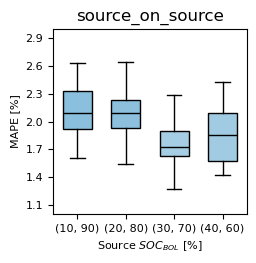

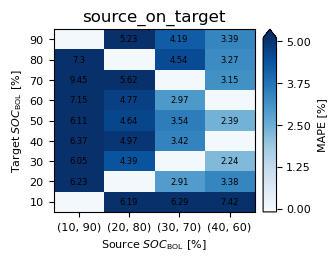

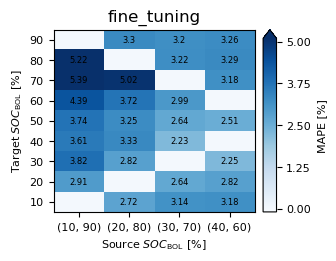

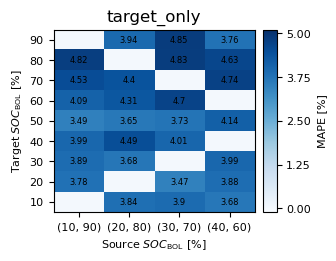

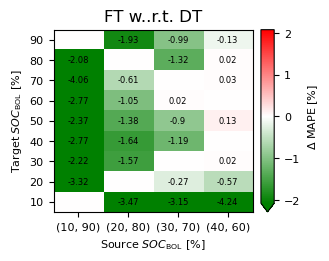

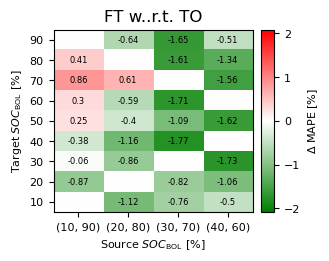

In [22]:
from scripts.modeling.fine_tuning import fine_tuning_result_keys

def get_multi_soc_error_results(dataset_id:str, pulse_type:str, results_to_show:str, error_metric:str, 
								return_type:str='mean', remove_outliers:bool=False, source_socs:Optional[list]=None) -> np.ndarray:
	"""Returns the SOC-combination results for the specified dataset and model (source-only, finetuning, target-only)

	Args:
		dataset_id (str): _description_
		pulse_type (str): {'chg', 'dchg'}
		results_to_show (str): {'source_on_source', 'source_on_target', 'target_only', 'fine_tuning'}
		error_metric (str): {'rmse', 'mae', 'mape', 'r2'}
		return_type (str, optional): {'mean', 'std', 'values'}. What to return for each SOC combination (e.g., the mean of values, the std, the raw values, et). Defaults to 'mean'.
		remove_outliers (bool, optional): Will drop any outliers before taking the mean or standard deviation. Outliers are only dropped if 'return_type' is not equal to 'values' Defaults to False
		source_socs (list, optional): Can optionally specify specific combinations (eg. [(10,90), (20,80)]. Defaults to None.
	Raises:
		ValueError: if specified source_socs is not in results.
	Returns:
		np.ndarray: A 2-dimensional array of the results. Use [target_soc][source_soc] to access individual results -> eg. results[0][1] = 20% SOC to 10% SOC
	"""

	assert dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']
	assert pulse_type in ['chg', 'dchg']
	assert results_to_show in ['source_on_source', 'source_on_target', 'target_only', 'fine_tuning']
	assert error_metric in ['rmse', 'mae', 'mape', 'r2']
	assert return_type in ['mean', 'std', 'values']

	#region: load results
	f_saved_results = dir_results.joinpath("finetuning_optimization", "st_split_by_cell", "MultiSourceSOC_to_SingleTargetSOC_2t1")
	assert f_saved_results.is_dir(), f"Cannot find directory: {f_saved_results}"
	dfs = [] 
	for file in f_saved_results.glob('*.pkl'):
		dfs.append(pickle.load(open(file, 'rb')))
	df = pd.concat(dfs, ignore_index=True)
	df.drop_duplicates(subset=['dataset_id', 'pulse_type', 'source_soc', 'target_soc', 'rand_seed'], inplace=True)
	#endregion

	#region: get errors corresponding to 'results_to_show'
	df_filt = df.loc[(df['dataset_id'] == dataset_id) & (df['pulse_type'] == pulse_type)]
	source_soc_groups = sorted(df_filt['source_soc'].astype(str).unique())

	if source_socs is not None:
		source_socs = [str(s) for s in source_socs]
		for soc_comb in source_socs: 
			if not soc_comb in source_soc_groups: raise ValueError(f"No results exist for {soc_comb}")
		df_filt = df_filt.loc[df_filt['source_soc'].isin(source_socs)]
		source_soc_groups = sorted(df_filt['source_soc'].astype(str).unique())

	# ensure that all SOC results have the same number of iterations
	min_length = None
	for source_soc in source_socs:
		n_iters = len(df_filt.loc[df_filt['source_soc'] == str(source_soc), 'rand_seed'].unique())
		if min_length is None or n_iters < min_length: min_length = n_iters
	df_filt = df_filt.loc[df_filt['rand_seed'] < min_length]
	
	target_socs = sorted(df_filt['target_soc'].astype(int).unique())
	results = np.zeros(shape=(len(target_socs), len(source_soc_groups)))
	if return_type == 'values':
		results = []
	for i, target_soc in enumerate(target_socs):
		if return_type == 'values': results.append([])
		for j, source_soc in enumerate(source_soc_groups):
			source_soc_tuple = tuple(map(int, source_soc.strip("()").split(",")))
			if target_soc in source_soc_tuple:
				if return_type == 'values': results[-1].append([])
				continue

			df_soc = df_filt.loc[(df_filt['source_soc'] == source_soc) & (df_filt['target_soc'].astype(int) == target_soc)]

			#region: remove outliers in any of the error metric columns if specified
			if remove_outliers and not (return_type == 'values'):
				err_cols = [f'source_{error_metric}', f'dt_{error_metric}', f'new_{error_metric}', f'ft_{error_metric}']
				err_cols = [err for err in err_cols if err in list(df_soc.columns)]
				from scipy import stats
				df_soc = df_soc[(np.abs(stats.zscore(df_soc[err_cols])) < 3.0).all(axis=1)]
			#endregion

			error_key = f"{fine_tuning_result_keys['model_error_names'][results_to_show]}_{error_metric}"
			values = df_soc[error_key].values * (100 if error_metric == 'mape' else 1)
			
			if return_type == 'mean': results[i,j] = np.mean(values)
			elif return_type == 'std': results[i,j] = np.std(values)
			elif return_type == 'values': results[-1].append(values)            
	#endregion

	#region: if returning raw values, we need to replace non-entries with array of zeros
	if return_type == 'values':
		num_vals = 0
		for i in range(len(results)):
			for j in range(len(results[0])):
				if len(results[i][j]) > num_vals: 
					num_vals = len(results[i][j])
		for i in range(len(results)):
			for j in range(len(results[0])):
				if len(results[i][j]) == 0: 
					results[i][j] = np.zeros(shape=num_vals)
		results = np.asarray(results)
	#endregion

	return np.asarray(results), source_soc_groups


dataset_id = 'UConn-ILCC-NMC'
pulse_type = 'dchg'
source_socs = [(10,90), (20,80), (30,70), (40,60)]
error_metric = 'mape'
file_type = 'png'
save = False


dir_save = dir_figures.joinpath("Fine-Tuning Error", "MultiSOC Source Model")
dir_save.mkdir(exist_ok=True, parents=True)


#region: plot absolute error
#region: plot source_on_source as boxplots
res, source_socs = get_multi_soc_error_results(
	dataset_id=dataset_id,
	pulse_type=pulse_type,
	results_to_show='source_on_source',
	error_metric=error_metric,
	return_type='values',
	remove_outliers=False,
	source_socs=source_socs
)
res = np.nan_to_num(res)
res_dict = {}
for col in range(res.shape[1]):
	all_errs = res[:, col][np.where(res[:, col] != 0)]
	res_dict[f'{source_socs[col]}'] = all_errs


figsize = (2.5,2.4)
err_bounds = (1.1, 2.9)
show_outliers = False

fig, ax = plt.subplots(figsize=figsize)
bplot = ax.boxplot(res_dict.values(), labels=res_dict.keys(),
				patch_artist=True, 
				widths=0.6 if dataset_id == 'UConn-ILCC-NMC' else 0.75,
				showfliers=show_outliers,
				flierprops={'marker': '.', 'markersize': 5})

# fill each boxplot with color base on MAPE error
scm = mpl.cm.ScalarMappable(cmap=mpl.cm.Blues, norm=mpl.colors.Normalize(vmin=0, vmax=5))
colors = [scm.to_rgba(np.mean(res_dict[k])) for k in res_dict.keys()]
for patch, median, color in zip(bplot['boxes'], bplot['medians'], colors):
	patch.set_facecolor(color)
	patch.set_edgecolor('black')
	median.set_color('black')
ax.set_xlabel(f"Source {soc_bol} [%]", fontsize=8)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), fontsize=8)
ax.set_ylabel(f"{error_metric.upper()} [{get_unit_str_from_error_metric(error_metric=error_metric, test_variable_unit='%')}]", fontsize=8)

if err_bounds is None:
	all_vals = None
	if show_outliers:
		all_vals = np.asarray(list(res_dict.values())).flatten()
	else:
		all_vals = []
		for whisker in bplot['whiskers']:
			all_vals.extend(whisker.get_data()[1])	# get y_data from each whisker
	err_bounds = (np.floor(np.min(all_vals)), np.ceil(np.max(all_vals)))
ax.set_ylim((1,3.0))
ax.set_yticks(np.arange(err_bounds[0], err_bounds[1]+0.05, 0.3), np.arange(err_bounds[0], err_bounds[1]+0.05, 0.3).round(2), fontsize=8)
ax.set_title("source_on_source")
filename = f"Error_{dataset_id}_{pulse_type}_{'so'}.{file_type}"
if save: plt.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
plt.show()
#endregion

shorthand_map = {'source_on_target':'dt', 'fine_tuning':'ft', 'target_only':'to'}
for result_to_show in ['source_on_target', 'fine_tuning', 'target_only']:
	res, source_socs = get_multi_soc_error_results(
		dataset_id=dataset_id,
		pulse_type=pulse_type,
		results_to_show=result_to_show,
		error_metric='mape',
		return_type='mean',
		remove_outliers=False,
		source_socs=source_socs
	)
	res = np.nan_to_num(res)

	soc_bol = r"$SOC_{\mathrm{BOL}}$"
	fig, axes, cbar = plot_soc_combination_grid(
		results=res,
		figsize=(3.25, 2.5), 
		title=result_to_show,
		xlabel=f'Source {soc_bol} [%]',
		ylabel=f'Target {soc_bol} [%]',
		xticklabels=[str(s) for s in source_socs],
		yticklabels=np.arange(10,91,10),
		error_bounds=(0,5),
	)
	cbar.set_label("MAPE [%]", fontsize=8)
	cbar.ax.tick_params(labelsize=8)
	axes[0].set_xticks(axes[0].get_xticks(), axes[0].get_xticklabels(), fontsize=8)
	axes[0].set_xlabel(axes[0].get_xlabel(), fontsize=8)
	axes[0].set_yticks(axes[0].get_yticks(), axes[0].get_yticklabels(), fontsize=8)
	axes[0].set_ylabel(axes[0].get_ylabel(), fontsize=8)

	for (j,i), label in np.ndenumerate(res):
		# add results value to center of square
		if not label == 0:
			axes[0].text(i,j, round(label,2), ha='center', va='center', fontsize=6)
	
	filename = f"Error_{dataset_id}_{pulse_type}_{shorthand_map[result_to_show]}.{file_type}"
	if save: plt.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
	plt.show()
#endregion


#region: get DT and TO errors and plot relative error

#region: get FT absolute MAPE
res_ft, source_socs = get_multi_soc_error_results(
	dataset_id=dataset_id,
	pulse_type=pulse_type,
	results_to_show='fine_tuning',
	error_metric='mape',
	return_type='mean',
	remove_outliers=False,
	source_socs=source_socs
)
res_ft = np.nan_to_num(res_ft)
#endregion

#region: get DT absolute MAPE
res_dt, source_socs = get_multi_soc_error_results(
	dataset_id=dataset_id,
	pulse_type=pulse_type,
	results_to_show='source_on_target',
	error_metric='mape',
	return_type='mean',
	remove_outliers=False,
	source_socs=source_socs
)
res_dt = np.nan_to_num(res_dt)
#endregion

#region: get TO absolute MAPE
res_to, source_socs = get_multi_soc_error_results(
	dataset_id=dataset_id,
	pulse_type=pulse_type,
	results_to_show='target_only',
	error_metric='mape',
	return_type='mean',
	remove_outliers=False,
	source_socs=source_socs
)
res_to = np.nan_to_num(res_to)
#endregion

#region: plot FT-DT
res_ft_dt = AbsoluteChange(res_ft, res_dt)

fig, axes, cbar = plot_soc_combination_grid(
	results=res_ft_dt,
	figsize=(3.18, 2.5), 
	title="FT w..r.t. DT",
	xlabel=f'Source {soc_bol} [%]',
	ylabel=f'Target {soc_bol} [%]',
	xticklabels=[str(s) for s in source_socs],
	yticklabels=np.arange(10,91,10),
	cmap=mpl.colors.LinearSegmentedColormap.from_list('rg',["green", "white", "red"], N=256),
	error_bounds=(-2,2),
	cbar_nticks=5
)
cbar.set_label(r"$\Delta$ MAPE [%]", fontsize=8)
cbar.ax.tick_params(labelsize=8)
axes[0].set_xticks(axes[0].get_xticks(), axes[0].get_xticklabels(), fontsize=8)
axes[0].set_xlabel(axes[0].get_xlabel(), fontsize=8)
axes[0].set_yticks(axes[0].get_yticks(), axes[0].get_yticklabels(), fontsize=8)
axes[0].set_ylabel(axes[0].get_ylabel(), fontsize=8)

for (j,i), label in np.ndenumerate(res_ft_dt):
	# add results value to center of square
	if label == 0: continue
	axes[0].text(i,j, round(label,2), ha='center', va='center', fontsize=6)

filename = f"Error_{dataset_id}_{pulse_type}_{'ft-dt'}.{file_type}"
if save: plt.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
plt.show()
#endregion

#region: plot FT-TO
res_ft_to = AbsoluteChange(res_ft, res_to)

fig, axes, cbar = plot_soc_combination_grid(
	results=res_ft_to,
	figsize=(3.18, 2.5), 
	title="FT w..r.t. TO",
	xlabel=f'Source {soc_bol} [%]',
	ylabel=f'Target {soc_bol} [%]',
	xticklabels=[str(s) for s in source_socs],
	yticklabels=np.arange(10,91,10),
	cmap=mpl.colors.LinearSegmentedColormap.from_list('rg',["green", "white", "red"], N=256),
	error_bounds=(-2,2),
	cbar_nticks=5
)
cbar.set_label(r"$\Delta$ MAPE [%]", fontsize=8)
cbar.ax.tick_params(labelsize=8)
axes[0].set_xticks(axes[0].get_xticks(), axes[0].get_xticklabels(), fontsize=8)
axes[0].set_xlabel(axes[0].get_xlabel(), fontsize=8)
axes[0].set_yticks(axes[0].get_yticks(), axes[0].get_yticklabels(), fontsize=8)
axes[0].set_ylabel(axes[0].get_ylabel(), fontsize=8)

for (j,i), label in np.ndenumerate(res_ft_to):
	# add results value to center of square
	if label == 0: continue
	axes[0].text(i,j, round(label,2), ha='center', va='center', fontsize=6)

filename = f"Error_{dataset_id}_{pulse_type}_{'ft-to'}.{file_type}"
if save: plt.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
plt.show()
#endregion

#endregion


## Source-Target Split by Cycling Group

* 8 groups used in source (then a 2:1 train:test split by cell)
* 3 groups used in target (3 cells for FT in NMC, 5 cells for FT in LFP)

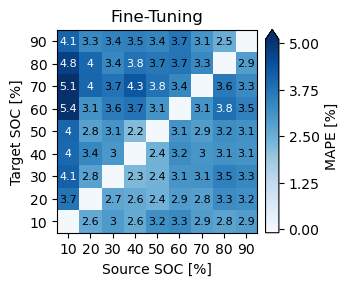

In [23]:
dataset_id = 'UConn-ILCC-NMC'
pulse_type = 'chg'
all_socs = dic_available_dataset_info[dataset_id]['pulse_socs_tested']

res = get_soc_error_results(
	dataset_id=dataset_id,
	pulse_type=pulse_type,
	results_to_show='fine_tuning', 
	error_metric='mape', 
	return_type='mean',
	remove_outliers=False,
    split_by='group')

fig, ax, cbar = plot_soc_combination_grid(
    results=res,
    annotations=res.round(1),
    
	figsize=(3.375,2.75),
    title='Fine-Tuning', 
    xlabel='Source SOC [%]',
    ylabel='Target SOC [%]',
    xticklabels=all_socs,
    yticklabels=all_socs,
    error_bounds=(0,5),
    annotation_fontsize=8,
)
cbar.set_label("MAPE [%]")

-0.58867599287673

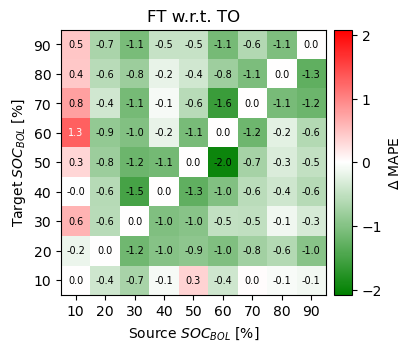

In [24]:
res = get_finetuning_errors(
	dataset_id='UConn-ILCC-NMC',
	pulse_type='chg',
	results_to_compare=('fine_tuning', 'target_only'),
	error_metric='mape',
	error_difference_fnc=AbsoluteChange,
	remove_outliers=False,
    split_by='cell'
)

fig, ax, cbar = plot_finetuning_errors(
	results=res,
	annotation_type=['mean'],

	figsize=(4,3.4),
	annotation_fontsize=7,
	cmap=mpl.colors.LinearSegmentedColormap.from_list('rg',["green", "white", "red"], N=256),
	error_bounds=(-2,2),
	cbar_nticks=5)
cbar.set_label(r"$\Delta$ MAPE")

np.average(res['mean'][res['mean'] != 0.0])